# Determination of the camera bias setting

The bias of dedicated astronomical cameras is adjustable. It must be set not too low so that data values are not clipped, but not too high so that the dynamic range is reduced. The bias can be measured by taking zero-second exposures, so there is no photon signal, and no thermal signal.
In [APS](https://en.wikipedia.org/wiki/Active-pixel_sensor) cameras (like the ASI2600 MM Cool used here, which uses a monochrome version of the [IMX571](https://www.sony-semicon.com/files/62/pdf/p-13_IMX571BQR_Flyer.pdf) chip), the bias value is different for every pixel, because there is one ADC (analog to digital converter) per pixel or per row / column. In [CCD](https://en.wikipedia.org/wiki/Charge-coupled_device)-based (charge-coupled device) cameras, there is a single ADC for the whole chip and thus a single bias value. The bias values in APSs are however very similar across the sensor and the variations in a bias frame are largely dominated by the read noise, as shown by taking a single exposure (gain 100, bias 15).

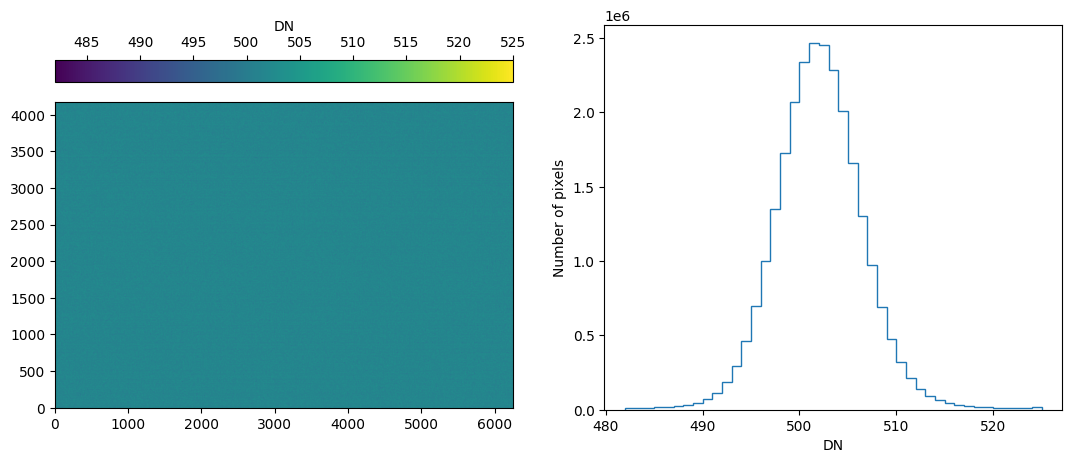

In [1]:
import glob
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import PercentileInterval, LinearStretch, ImageNormalize

# change to your file
file = r'C:\Users\fauchere\Pictures\ZWO ASI2600MM Pro\2023-07-08\BIAS\G100\2023-07-08_20-32-47__5.80_0.00s_0003.fits'

bias_frame = fits.getdata(file)

norm = ImageNormalize(bias_frame, stretch=LinearStretch(), interval=PercentileInterval(99))
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
img = ax[0].imshow(bias_frame, origin='lower', norm=norm)
bar = plt.colorbar(img, location='top')
bar.set_label('DN')
h = ax[1].hist(bias_frame.flatten(), bins=int(norm.vmax - norm.vmin), range=[norm.vmin, norm.vmax], histtype='step')
l = ax[1].set_xlabel('DN')
l = ax[1].set_ylabel('Number of pixels')

The center of the histogram shown on the right is the average bias value over the whole frame. The variations around that value come from variations of the individual bias values and from read noise. We can estimate the variations of the bias itself by averaging a large number of bias frames. For each pixel, the bias value is constant while  the read noise is random. The average of a large number of samples will thus tend to the bias value.

The variations of the read noise are amplified by the gain setting, and the width of the distribution shown above will thus vary accordingly. It is therefore necessary to determine the optimal bias value for each gain setting.

## Data acquisition

Test two gain settings, 100 and 200.

- For gain 100, take single exposures at increasing bias values, from 0 to 50 by steps of 5
- For gain 200, take single exposures at increasing bias values, from 0 to 140 by steps of 10

Store the data in two separate folders.

## Data reduction

We start by displaying the histogram of values in each frame, for each gain.

100%|██████████| 26/26 [00:48<00:00,  1.88s/it]


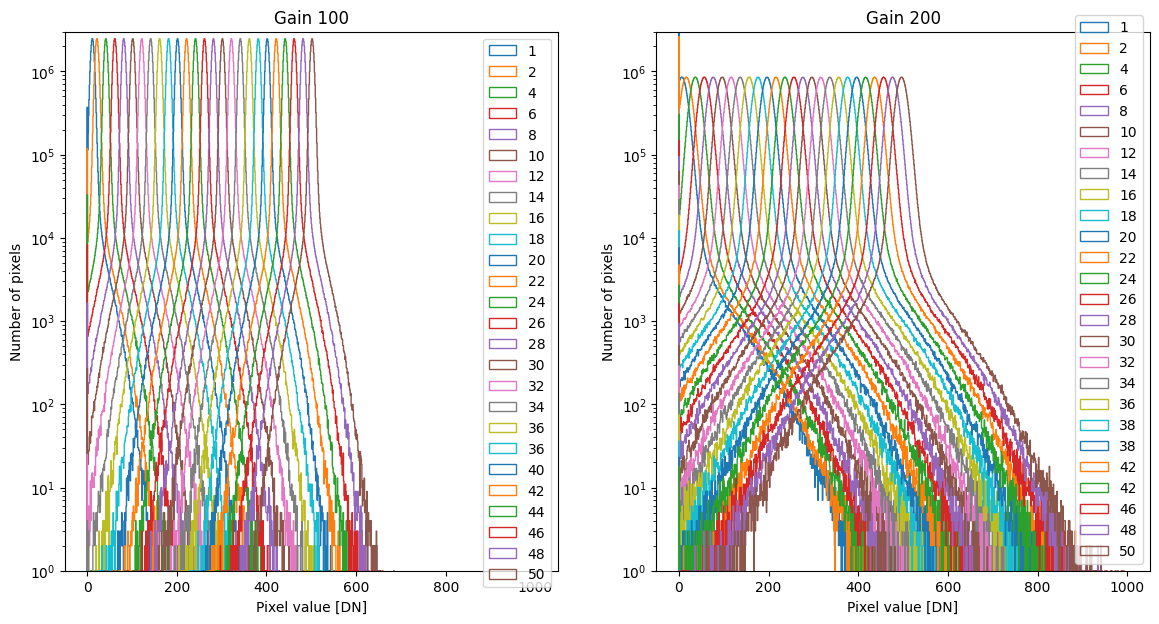

In [3]:
import numpy as np
from tqdm import tqdm

# change to the two folders in which the data was saved
paths = [r'C:\Users\fauchere\Pictures\ZWO ASI2600MM Pro\2023-07-08\BIAS\G100',
         r'C:\Users\fauchere\Pictures\ZWO ASI2600MM Pro\2023-07-08\BIAS\G200']

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

offsets_per_gain = []  # used to store the offset values for each gain
zeros_per_gain = []  # used to store the number of zero-valued pixels for each gain

for path, ax, title in zip(paths, axes.flatten(), ['Gain 100', 'Gain 200']):

    files = glob.glob(os.path.join(path, '*.fits'))
    offsets = np.array([fits.getheader(file)['OFFSET'] for file in files])
    offsets, files = zip(*sorted(zip(offsets, files)))
    offsets_per_gain.append(offsets)

    zeros = []
    for file, offset in tqdm(zip(files, offsets), total=len(files)):
        data = fits.getdata(file)
        zero = (data <= 4).sum()
        zeros.append(zero)
        ax.hist(data.flatten(), histtype='step', bins=1000, range=[0, 1000], label=f'{offset}')

    zeros_per_gain.append(zeros)

    ax.set_xlabel('Pixel value [DN]')
    ax.set_ylabel('Number of pixels')
    ax.set_ylim(1, 3e6)
    ax.set_yscale('log')
    ax.set_title(title)
    ax.legend()

The core of the distributions are Gaussians (parabolic shape in log-scale), with extended exponential wings. In order to determine which gain setting prevents clipping of the low values, we display the number of zero-valued pixels as a function of the bias.

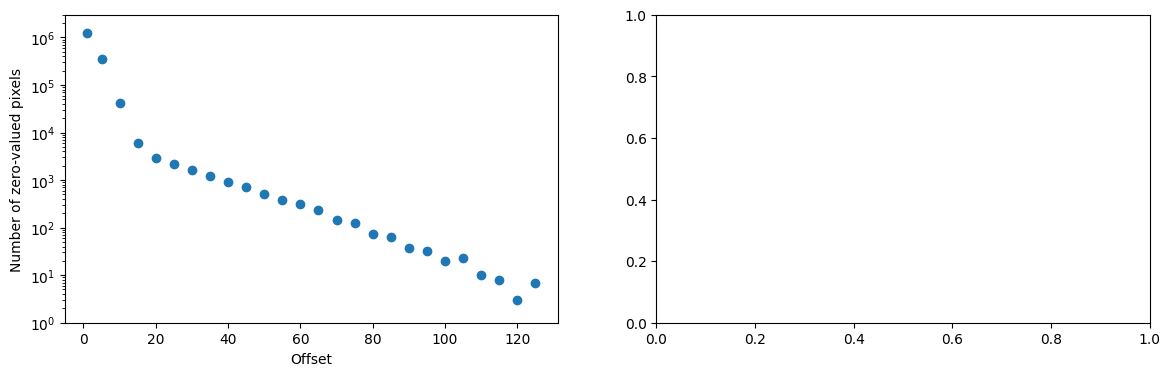

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, offsets, zeros in zip(axes.flatten(), offsets_per_gain, zeros_per_gain):
    ax.scatter(offsets, zeros)
    ax.set_xlabel('Offset')
    ax.set_ylabel('Number of zero-valued pixels')
    ax.set_yscale('log')
    ax.set_ylim(1, 3e6)

## Interpretation

From the above, determine the optimal bias setting for each gain.